# Small Area Health Insurance Estimates (SAHIE) using the American Community Survey (ACS)

Data are available through the United States Census Bureau website.

https://www.census.gov/data/datasets/time-series/demo/sahie/estimates-acs.html

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

File Layout and Definitions: 
 
    Variable      Format      Description     
       year            4      Year of Estimate
       version         8      Release Version 
                                 Blank   : YEAR other than 2013, Only Version   
                                 Original: 2013 only, Original Version          
                                 Updated : 2013 only, Updated Version (May 2016)
       statefips       2      Unique FIPS code for each state                   
       countyfips      3      Unique FIPS code for each county within a state   
       geocat          2      Geography category             
                                40 - State geographic identifier 
                                50 - County geographic identifier
       agecat          1      Age category        
                                0 - Under 65 years
                                1 - 18 to 64 years
                                2 - 40 to 64 years
                                3 - 50 to 64 years
                                4 - Under 19 years
                                5 - 21 to 64 years
       racecat         1      Race category  
                                0 - All races
                                Only state estimates have racecat=1,2,3 values
                                1 - White alone, not Hispanic
                                2 - Black alone, not Hispanic
                                3 - Hispanic (any race)      
       sexcat          1      Sex category    
                                0 - Both sexes
                                1 - Male      
                                2 - Female    
       iprcat          1      Income category 
                                0 - All income levels          
                                1 - At or below 200% of poverty
                                2 - At or below 250% of poverty
                                3 - At or below 138% of poverty
                                4 - At or below 400% of poverty
                                5 - Between 138% - 400%  of poverty
      NIPR             8      Number in demographic group for <income category>
         nipr_moe      8           MOE  for NIPR
      NUI              8      Number uninsured  
         nui_moe       8           MOE  for NUI 
      NIC              8      Number insured    
         nic_moe       8           MOE  for NIC 
      PCTUI            5.1    Percent uninsured in demographic group for <income category>
         pctui_moe     5.1         MOE  for PCTUI                                 
      PCTIC            5.1    Percent insured in demographic group for <income category>  
         pctic_moe     5.1         MOE  for PCTIC                                 
      PCTELIG          5.1    Percent uninsured in demographic group for all income levels
         pctelig_moe   5.1         MOE  for PCTELIG                                
      PCTLIIC          5.1    Percent insured in demographic group for all income levels  
         pctliic_moe   5.1         MOE  for PCTLIIC                                
      state_name       70     State Name
      county_name      45     County Name
 
  PRIMARY KEY: year version statefips countyfips agecat racecat sexcat iprcat         
 
  Note 1:  A margin of error (MOE) is the difference between an estimate and its upper
  or lower confidence bounds. Confidence bounds can be created by adding the margin   
  of error to the estimate (for an upper bound) and subtracting the margin of error   
  from the estimate (for a lower bound). All published margins of error for the Small 
  Area Health Insurance Estimates program are based on a 90 percent confidence level. 
 
  Note 2:  The number in a demographic group is the number of people in the poverty   
  universe in that age, sex, and race/Hispanic origin group.                          
 
  Note 3:  Values for Kalawao, HI (15-005) should be considered N/A or missing.       
 
  Note 4:  MOEs of zero should be assumed to be <1 for counts and <0.1 for percentages.
 
  General Note:  Details may not sum to totals because of rounding.

In [4]:
data = pd.read_csv('sahie-2015-csv.zip',sep='\s*,\s*',skiprows=79,na_values='.',engine='python')

Let's plot just the aggregate state-level percentage of uninsured individuals.

In [5]:
states = data[(data['geocat'] == 40) & (data['agecat'] == 0) & 
              (data['racecat'] == 0) & (data['sexcat'] == 0) & (data['iprcat'] == 0)]
states = states.sort_values('PCTUI',ascending=False)

<IPython.core.display.Javascript object>


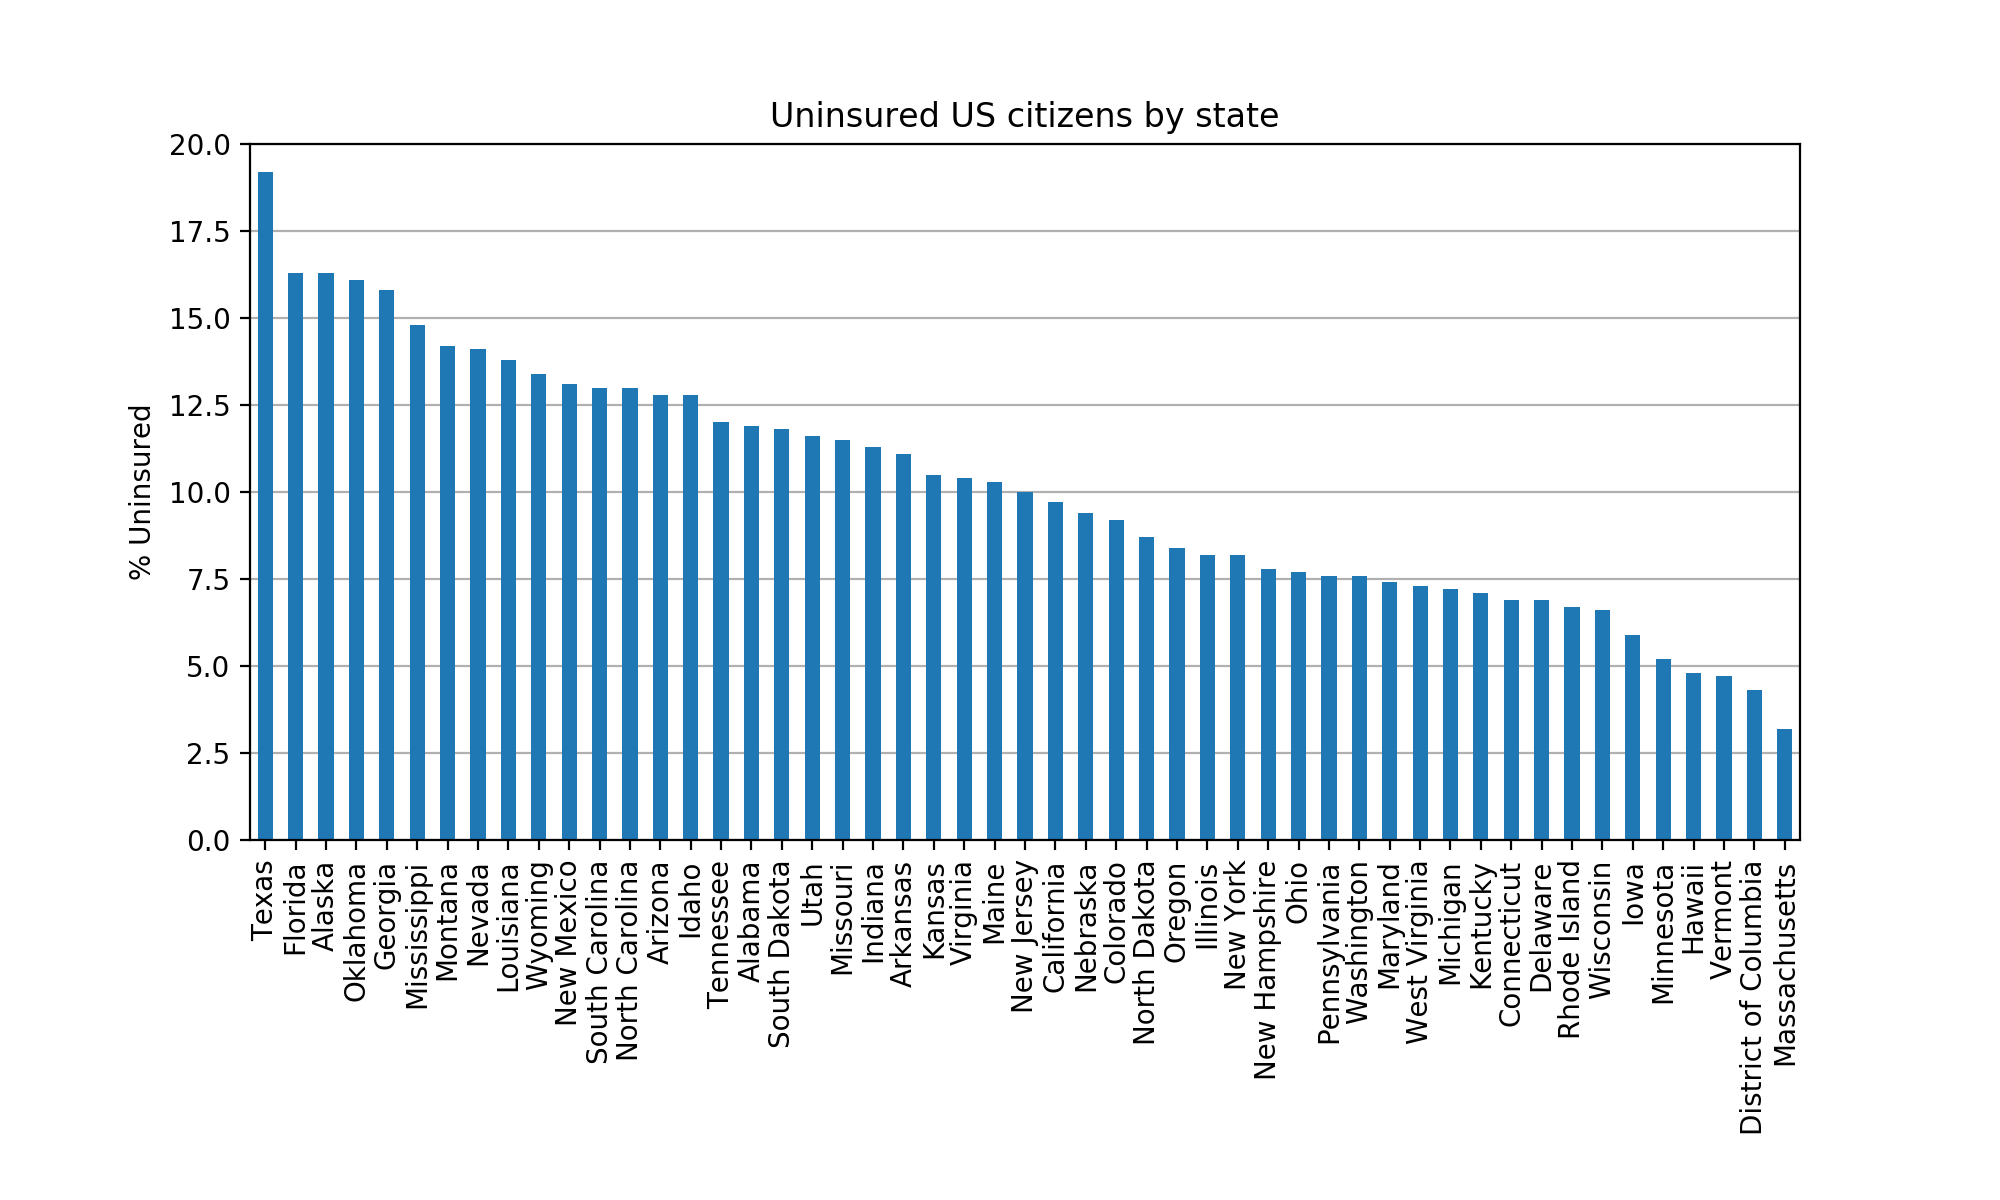

In [71]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
fig.subplots_adjust(bottom=0.3)
states.plot('state_name','PCTUI',kind='bar',ax=ax,legend=False,zorder=2)
ax.grid(zorder=1,axis='y')
ax.set_xlabel('')
ax.set_ylabel('% Uninsured')
ax.set_ylim(0,20)
ax.set_title('Uninsured US citizens by state')
plt.show()

Draw a map of the United States with county outlines using the Basemap toolkit for ```matplotlib``` located at https://github.com/matplotlib/basemap.

Borrowed some code used to color the county map for the 2016 US election from http://shallowsky.com/blog/programming/plotting-election-data-basemap.html.

In [24]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

Write a function which queries the chosen demographic for each county.

In [58]:
def query_data(data,age=0,race=0,sex=0,income=0):
    query = data[(data['geocat'] == 50) & (data['agecat'] == age) & 
              (data['racecat'] == race) & (data['sexcat'] == sex) & (data['iprcat'] == income)]
    return query

Plot the state and county outlines on a map using Basemap. Select the range of latititude and longitude for the plot. Note: if plotting across wide areas, the projection can get weird. Therefore, I have separate subplots for Hawaii and Alaska so that they look like they are oriented more or less North up, East right, etc.

In [68]:
def plot_map(latrange,lonrange,ax,resolution='c',projection='tmerc'):
    lllat = latrange[0]
    urlat = latrange[1]
    centerlat = np.mean(latrange)
    lllon = lonrange[0]
    urlon = lonrange[1]
    centerlon = np.mean(lonrange)
    m = Basemap(resolution=resolution,  # crude, low, intermediate, high, full
            llcrnrlon = lllon, urcrnrlon = urlon,
            lon_0 = centerlon,
            llcrnrlat = lllat, urcrnrlat = urlat,
            lat_0 = centerlat,
            projection=projection,ax=ax)
    
    shp_info = m.readshapefile('st99_d00', 'states',
                           drawbounds=True, color='lightgrey')
    
    shp_info = m.readshapefile('cb_2015_us_county_500k',
                           'counties',
                           drawbounds=True)

    return m

Color the counties by percentage of uninsured. This function automatically normalizes the color scale to be ```vmin=0``` and ```vmax=data['PCTUI'].max()```. This maximum value can also be set manually in case you want to keep the same normalization over several different plots.

In [69]:
def color_counties(data,m,ax,mak=None,axak=None,mha=None,axha=None,norm='auto',cmap=plt.cm.viridis):
    if norm == 'auto':
        maxval = data['PCTUI'].max()
    else:
        maxval = norm
    for i, county in enumerate(m.counties_info):
        sfp = int(county['STATEFP'])
        cfp = int(county['COUNTYFP'])
        query = data['PCTUI'][(counties['statefips'] == sfp) & (counties['countyfips'] == cfp)]
        if query.size == 0:
            ccolor = 'white'
        else:
            ccolor = cmap(query.iloc[0]/maxval)
            
        countyseg = m.counties[i]
        poly = Polygon(countyseg, facecolor=ccolor) 
        
        if mak is not None and axak is not None and sfp == 2:
            countyseg = mak.counties[i]
            poly = Polygon(countyseg, facecolor=ccolor)  
            axak.add_patch(poly)
        elif mha is not None and axha is not None and sfp == 15:
            countyseg = mha.counties[i]
            poly = Polygon(countyseg, facecolor=ccolor)  
            axha.add_patch(poly)
        else:
            countyseg = m.counties[i]
            poly = Polygon(countyseg, facecolor=ccolor)  
            ax.add_patch(poly)
            
    return maxval

Here's where we put it all together. I made a grid of subplots so that Hawaii and Alaska are scaled in size appropriately with the continental US (not perfect).

This takes about 10-20 seconds to run because it takes awhile to draw the county lines. It's plotting all of the counties for each subplot, and unfortunately, there doesn't seem to be an easy way to fix that...

The colorbar is set to be whatever the range of values for ```color_counties()``` used.

<IPython.core.display.Javascript object>


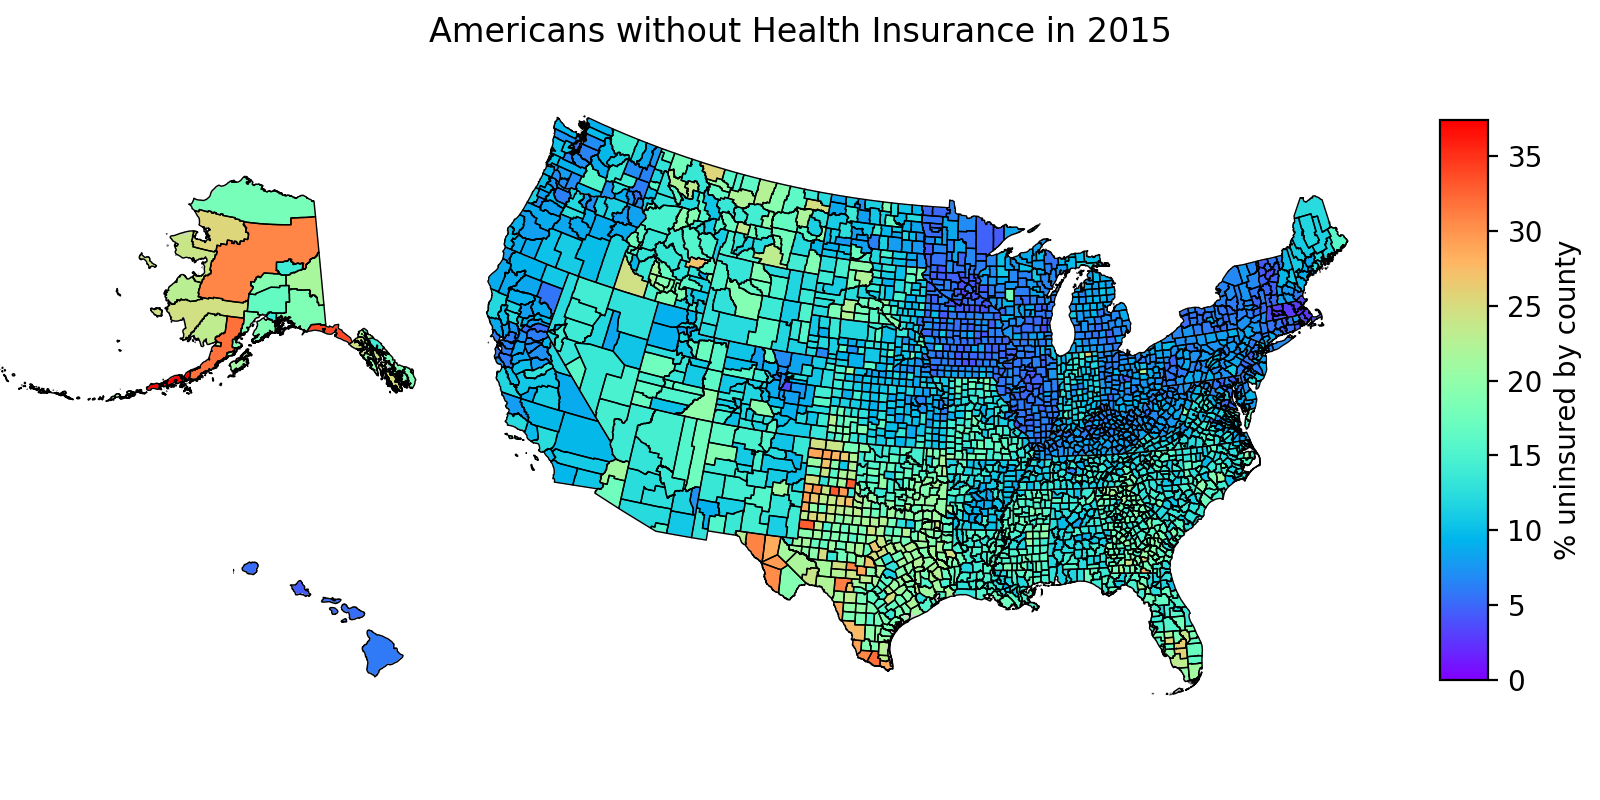

In [70]:
%matplotlib notebook

## set up axes
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(left=0,right=0.85)
ax1 = plt.subplot2grid((3,6),(0,0),rowspan=2,colspan=2)
ax2 = plt.subplot2grid((3,6),(2,1))
ax3 = plt.subplot2grid((3,6),(0,2),rowspan=3,colspan=4)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

## draw the counties
m1 = plot_map([48,70],[-179,-115],ax1)
m2 = plot_map([18.5,22.5],[-160,-154],ax2)
m3 = plot_map([22.0,50.5],[-119,-63],ax3)

## Title the plot
plt.suptitle('Americans without Health Insurance in 2015')

## this is where you select which specific demographic you want to query
## a zero is selecting all available data on the demographic
query = query_data(data,age=0,race=0,sex=0,income=0)

## select your desired color map here
cmap = plt.cm.rainbow

## color the counties by percent uninsured
maxval = color_counties(query,m3,ax3,mak=m1,axak=ax1,mha=m2,axha=ax2,norm='auto',cmap=cmap)

## add a colorbar
cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
norm = Normalize(vmin=0,vmax=maxval)
cb = ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
cb.set_label('% uninsured by county')